# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
from scipy.signal import hilbert

In [3]:
import h5py

/home/bercea20/anaconda3/envs/openpmd/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os

In [5]:
base_dir = '/bigdata/hplsim/external/bercea20/runs/lwfa/nitro/3d'
out_dir = 'simOutput'
h5_dir = 'h5'

# 002

In [6]:
run_dir = '002'
h5_path = os.path.join(base_dir, run_dir, out_dir, h5_dir)

In [7]:
timestep = 20000
f_name = os.path.join(h5_path, 'h5_all_{}.h5'.format(timestep))
fields = '/data/{}/fields'.format(timestep)

In [8]:
f = h5py.File(f_name)
handler = f[fields]

In [9]:
rho_e = handler['e_chargeDensity']

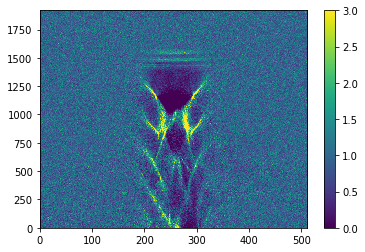

In [10]:
unit_factor = rho_e.attrs['unitSI'] / -1.6e-19 * 1e-6 / 7.111e18
plt.imshow(rho_e[256,:,:] * unit_factor, aspect='auto', vmax=3, origin='lower')
plt.colorbar();

In [11]:
convert_to_a0 = 1.6e-19 / (9.1e-31 * 2.9979e8 * 2 * np.pi * 2.9979e8 / 800.0e-9)

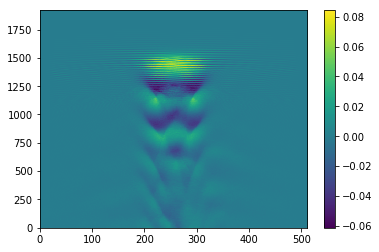

In [12]:
Ey = handler['E/y']
unit_factor = Ey.attrs['unitSI'] * convert_to_a0
plt.imshow(Ey[256,:,:] * unit_factor, aspect='auto', origin='lower')
plt.colorbar();

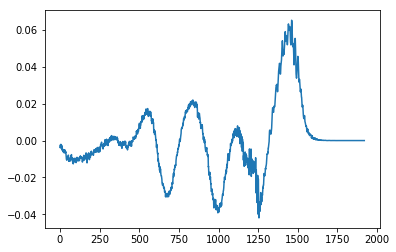

In [13]:
plt.plot(Ey[256,:,256] * unit_factor);

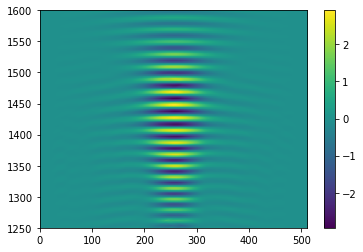

In [14]:
Ex = handler['E/x']
unit_factor = Ex.attrs['unitSI'] * convert_to_a0
plt.imshow(Ex[256,:,:] * unit_factor, aspect='auto', origin='lower')
plt.ylim(1250,1600)
plt.colorbar();

In [77]:
1500-1250

250

### compute a0

In [78]:
def get_a0_max_at(t_step, h5_folder):
    f_name = os.path.join(h5_folder, 'h5_all_{}.h5'.format(t_step))
    fields = '/data/{}/fields'.format(t_step)
    f = h5py.File(f_name)
    Ex_h = f[fields]['E/x']
    Ex = Ex_h[256,:,:] * Ex_h.attrs['unitSI']
    f.close()
    Ex *= convert_to_a0
    envelope = np.abs(hilbert(Ex, axis=0))
    envelope_y = envelope[:, 256]
    # env_y_mean = np.mean(envelope[:, :], axis=1)
    y_idx = np.argmax(envelope_y)
    a0_max = np.amax(envelope_y)
    fwhm_a0_perp = np.sum(np.greater_equal(envelope[y_idx, :], 0.5*a0_max))*0.1772e-6 #<-- CELL_WIDTH_SI 
    fwhm_a0_long = np.sum(np.greater_equal(envelope_y, 0.5*a0_max))*0.4430e-7 #<-- CELL_HEIGHT_SI 
    return t_step, a0_max, fwhm_a0_perp*1e6, fwhm_a0_long*1e6 # <-- in micrometers

In [79]:
get_a0_max_at(timestep, h5_path)

(20000, 2.9637796400364236, 15.770800000000001, 11.075)

### energy histograms

In [17]:
hist_path = os.path.join(base_dir, run_dir, out_dir)

In [18]:
tstep_to_pos = 3e8 * 1.39e-16 / 1e-3

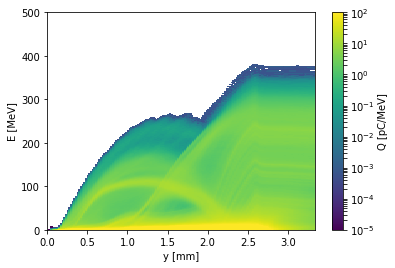

In [25]:
h_file = os.path.join(hist_path, 'e_nitro_energyHistogram_all.dat')
hist = np.loadtxt(h_file)

en_bins = np.linspace(0, 500, 1024)
y_axis = hist[:,0] * tstep_to_pos

plt.pcolormesh(y_axis, en_bins, hist[:,2:-2].T * 1.6e-19/1e-12 / (en_bins[1] - en_bins[0]),
               norm=LogNorm(), vmin=1e-5 , vmax=1e2)
plt.xlabel('y [mm]')
plt.ylabel('E [MeV]')
c = plt.colorbar()
c.set_label('Q [pC/MeV]')

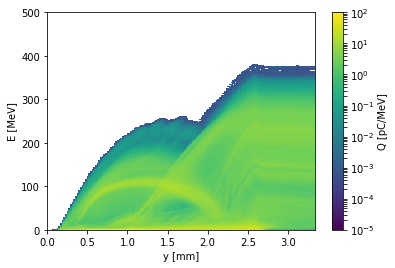

In [26]:
h_file = os.path.join(hist_path, 'e_nitro_energyHistogram_forwardPinhole.dat')
hist = np.loadtxt(h_file)

en_bins = np.linspace(0, 500, 1024)
y_axis = hist[:,0] * tstep_to_pos

plt.pcolormesh(y_axis, en_bins, hist[:,2:-2].T * 1.6e-19/1e-12 / (en_bins[1] - en_bins[0]),
               norm=LogNorm(), vmin=1e-5 , vmax=1e2)
plt.xlabel('y [mm]')
plt.ylabel('E [MeV]')
c = plt.colorbar()
c.set_label('Q [pC/MeV]')

In [81]:
tstep_v = np.arange(0, 80000+1, 2500)
a0_v = np.zeros_like(tstep_v, dtype=np.float32)
w0_perp = np.zeros_like(tstep_v, dtype=np.float32)
w0_long = np.zeros_like(tstep_v, dtype=np.float32)

In [82]:
print('y[mm] tstep a0_max fwhm_w0\n')
for i, tstep in enumerate(tstep_v):
    ts, a0, w0p, w0l = get_a0_max_at(tstep, h5_path)
    a0_v[i] = a0
    w0_perp[i] = w0p
    w0_long[i] = w0l
    print('{:03.1f}   {:5d}  {:04.2f} {:04.2f}'.format(ts * tstep_to_pos, ts, a0, w0p, w0l))

y[mm] tstep a0_max fwhm_w0

0.0       0  0.00 90.73
0.1    2500  2.98 16.83
0.2    5000  3.16 15.42
0.3    7500  4.14 11.70
0.4   10000  5.06 9.57
0.5   12500  4.92 10.10
0.6   15000  4.19 11.70
0.7   17500  3.38 14.53
0.8   20000  2.96 15.77
0.9   22500  2.95 14.88
1.0   25000  3.15 13.82
1.1   27500  3.34 13.29
1.3   30000  3.41 13.47
1.4   32500  3.30 14.00
1.5   35000  3.23 15.24
1.6   37500  3.08 15.59
1.7   40000  3.13 15.59
1.8   42500  2.99 15.95
1.9   45000  3.08 15.59
2.0   47500  3.17 14.88
2.1   50000  3.23 15.24
2.2   52500  3.28 15.95
2.3   55000  3.25 16.30
2.4   57500  3.02 17.54
2.5   60000  3.26 15.42
2.6   62500  3.45 14.53
2.7   65000  2.98 17.01
2.8   67500  2.26 21.97
2.9   70000  1.76 26.23
3.0   72500  1.42 29.95
3.1   75000  1.20 32.78
3.2   77500  1.03 35.79
3.3   80000  0.89 38.81


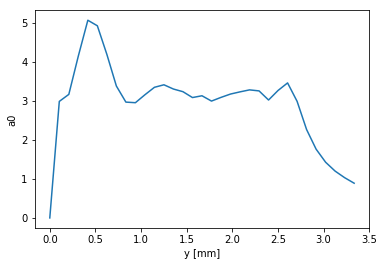

In [83]:
plt.plot(tstep_v* tstep_to_pos, a0_v)
plt.ylabel('a0')
plt.xlabel('y [mm]');

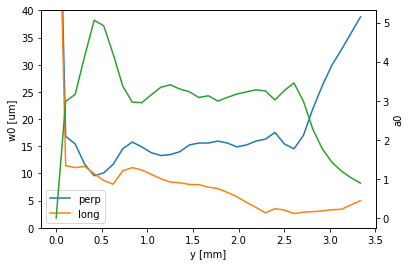

In [90]:
plt.plot(tstep_v* tstep_to_pos, w0_perp, label='perp')
plt.plot(tstep_v* tstep_to_pos, w0_long, label='long')
plt.ylim(0,40)
plt.ylabel('w0 [um]')
plt.xlabel('y [mm]');
plt.legend()
plt.twinx()
plt.plot(tstep_v* tstep_to_pos, a0_v, color='C2')
plt.ylabel('a0')
plt.xlabel('y [mm]');

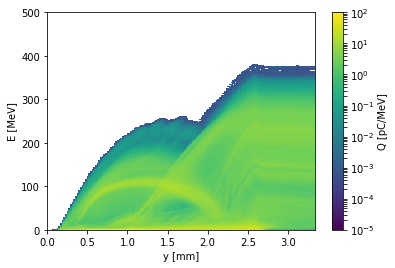

In [26]:
h_file = os.path.join(hist_path, 'e_nitro_energyHistogram_forwardPinhole.dat')
hist = np.loadtxt(h_file)

en_bins = np.linspace(0, 500, 1024)
y_axis = hist[:,0] * tstep_to_pos

plt.pcolormesh(y_axis, en_bins, hist[:,2:-2].T * 1.6e-19/1e-12 / (en_bins[1] - en_bins[0]),
               norm=LogNorm(), vmin=1e-5 , vmax=1e2)
plt.xlabel('y [mm]')
plt.ylabel('E [MeV]')
c = plt.colorbar()
c.set_label('Q [pC/MeV]')

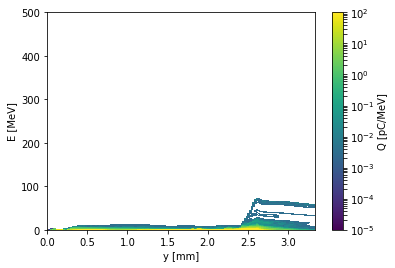

In [29]:
h_file = os.path.join(hist_path, 'e_energyHistogram_all.dat')
hist = np.loadtxt(h_file)

en_bins = np.linspace(0, 500, 1024)
y_axis = hist[:,0] * 3e8 * 1.39e-16 / 1e-3

plt.pcolormesh(y_axis, en_bins, hist[:,2:-2].T * 1.6e-19/1e-12 / (en_bins[1] - en_bins[0]), norm=LogNorm(),
              vmin=1e-5 , vmax=1e2)
plt.xlabel('y [mm]')
plt.ylabel('E [MeV]')
c = plt.colorbar()
c.set_label('Q [pC/MeV]')
#plt.ylim(0,10);

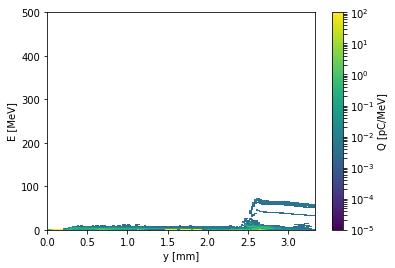

In [30]:
h_file = os.path.join(hist_path, 'e_energyHistogram_forwardPinhole.dat')
hist = np.loadtxt(h_file)

en_bins = np.linspace(0, 500, 1024)
y_axis = hist[:,0] * 3e8 * 1.39e-16 / 1e-3

plt.pcolormesh(y_axis, en_bins, hist[:,2:-2].T * 1.6e-19/1e-12 / (en_bins[1] - en_bins[0]), norm=LogNorm(),
              vmin=1e-5 , vmax=1e2)
plt.xlabel('y [mm]')
plt.ylabel('E [MeV]')
c = plt.colorbar()
c.set_label('Q [pC/MeV]')
#plt.ylim(0,10);